In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import seaborn as sns
import anndata

plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

# my code
%load_ext autoreload
%autoreload 2
from passenger.plot.plot import *


/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
patient = "P4"
adata = anndata.read_h5ad("/home/vmarotl/fast/mutaseq/scripts/figure_notebooks/processed_data/AML_MutaSeq/"+patient+".h5ad")
adata

AnnData object with n_obs × n_vars = 476 × 2487
    obs: 'celltype_full', 'celltype', 'cell_labels', 'cancer_weight', 'healthy_weight'
    var: 'chr', 'pos', 'ref', 'mut', 'REDIdb', 'dbSNP', 'gene', 'cancer_ref', 'cancer_alt', 'cancer_cov', 'healthy_ref', 'healthy_alt', 'healthy_cov'
    uns: 'C_dist', 'all_C', 'factor_labels', 'filter_germline', 'min_MAF', 'weighted_E'
    obsm: 'C', 'C_std', 'ref_assignments', 'umap'
    varm: 'V', 'V_std'
    layers: 'ALT', 'M', 'REF', 'weights'

In [4]:
NUP188_var_pos = 129005380

from scipy.io import mmread
from passenger.preprocess.import_data import *
path = "/home/vmarotl/fast/mutaseq/raw_data/P4/chr9/"
f = open(path+'/cellSNP.tag.AD.mtx', 'r')
ALT = pd.DataFrame(mmread(f).A)

f = open(path + '/cellSNP.tag.DP.mtx', 'r')
DP = pd.DataFrame(mmread(f).A)

REF = DP - ALT
meta = get_meta(path + '/cellSNP.base.vcf', path + '/annotations.tsv', "chr9", None)
pos = np.where(meta.pos == 129005380)[0][0]

mut = ALT.iloc[pos]
ref = REF.iloc[pos]

leuk_COV = mut+ref
leuk_VAF = mut/leuk_COV

#leuk_VAF[leuk_COV<=2]=np.nan
cell_names = patient+"_"+np.array(pd.read_csv("~/fast/mutaseq/raw_data/P4/filenames.txt", header=None)[0].str.split("/").str[-1].str.split("_").str[2])
leuk_VAF.index = cell_names
leuk_VAF = leuk_VAF.loc[adata.obs_names]

/tmp/6972453.1.all.q/ipykernel_23526/3008955699.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap["UMAP_1"][np.isnan(leuk_VAF)], umap["UMAP_2"][np.isnan(leuk_VAF)], color="lightgrey", s=20, cmap=var_cmap)


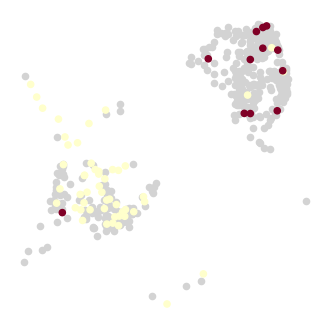

In [5]:
f,ax = plt.subplots(1,1, figsize=(4,4))

umap = adata.obsm["umap"]

plt.scatter(umap["UMAP_1"][np.isnan(leuk_VAF)], umap["UMAP_2"][np.isnan(leuk_VAF)], color="lightgrey", s=20, cmap=var_cmap)
plt.scatter(umap["UMAP_1"], umap["UMAP_2"], c=leuk_VAF, s=20, cmap=var_cmap)
#plt.colorbar()

ax.axis('off')
plt.savefig("../figures/AML-S2_P4_NUP188-VAF-UMAP.pdf", bbox_inches='tight', format='pdf', dpi=300)
plt.show()
plt.close()

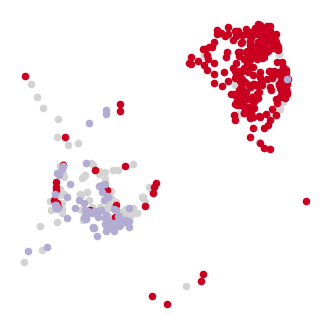

In [6]:
C = adata.obsm["C"]
sub_cells =np.abs(C[:,0]-C[:,1])>.3

f,ax = plt.subplots(1,1, figsize=(4,4))

cancer_cells = adata.obs["cell_labels"]=="cancer"
healthy_cells = adata.obs["cell_labels"]=="healthy"
undeterminded_cells = adata.obs["cell_labels"]=="undetermined"

umap = adata.obsm["umap"]
plt.scatter(umap["UMAP_1"][undeterminded_cells], umap["UMAP_2"][undeterminded_cells], color="lightgrey", s=20, label="undetermined")
plt.scatter(umap["UMAP_1"][cancer_cells], umap["UMAP_2"][cancer_cells], color="#ca0020", s=20, label="cancer")
plt.scatter(umap["UMAP_1"][healthy_cells], umap["UMAP_2"][healthy_cells], color="#b2abd2", s=20, label="healthy")
#plt.legend()

ax.axis('off')
plt.savefig("../figures/AML-S2_P4_our-labels-UMAP.pdf", bbox_inches='tight', format='pdf', dpi=300)
plt.show()
plt.close()

In [7]:
sub_cells = adata.obs["cell_labels"]!="undetermined"
sort_by = pd.DataFrame(adata.obsm["C"]>.5, index = adata.obs_names).loc[sub_cells]
row_ind = sort_by.sort_values([0,1,2],ascending=True).index # sort by know assignments
adata = adata[row_ind]

C = adata.obsm["C"]
V = adata.varm["V"]

adata

View of AnnData object with n_obs × n_vars = 360 × 2487
    obs: 'celltype_full', 'celltype', 'cell_labels', 'cancer_weight', 'healthy_weight'
    var: 'chr', 'pos', 'ref', 'mut', 'REDIdb', 'dbSNP', 'gene', 'cancer_ref', 'cancer_alt', 'cancer_cov', 'healthy_ref', 'healthy_alt', 'healthy_cov'
    uns: 'C_dist', 'all_C', 'factor_labels', 'filter_germline', 'min_MAF', 'weighted_E'
    obsm: 'C', 'C_std', 'ref_assignments', 'umap'
    varm: 'V', 'V_std'
    layers: 'ALT', 'M', 'REF', 'weights'

In [8]:
# define some helper for simplicity in plotting
VAF = (adata.layers["ALT"]/(adata.X))
VAF[adata.X<=2]=np.nan
V = adata.varm["V"]

clones = np.argmax(C, axis=1)
expressed = np.any(V>=0, axis=1)
for i in np.unique(clones): # only variants covered in both clones
    expressed &= np.sum(adata[(clones==i)].X>=2, axis=0)>(.2*np.sum((clones==i)))
    expressed &= np.sum(adata[(clones==i)].X>=2, axis=0)>20

WE_cov = np.array([adata.var.cancer_ref+adata.var.cancer_alt,
                        adata.var.healthy_ref+adata.var.healthy_alt]
                        )
WE_VAF = (np.array([adata.var.cancer_alt,
                        adata.var.healthy_alt]
                        )/WE_cov).T
WE_VAF[WE_cov.T<=10]=np.nan

/home/vmarotl/anaconda3/envs/passenger/lib/python3.10/site-packages/anndata/_core/views.py:113: RuntimeWarning: invalid value encountered in divide
  results = super().__array_ufunc__(
/tmp/6972453.1.all.q/ipykernel_23526/2494128066.py:15: RuntimeWarning: invalid value encountered in divide
  WE_VAF = (np.array([adata.var.cancer_alt,


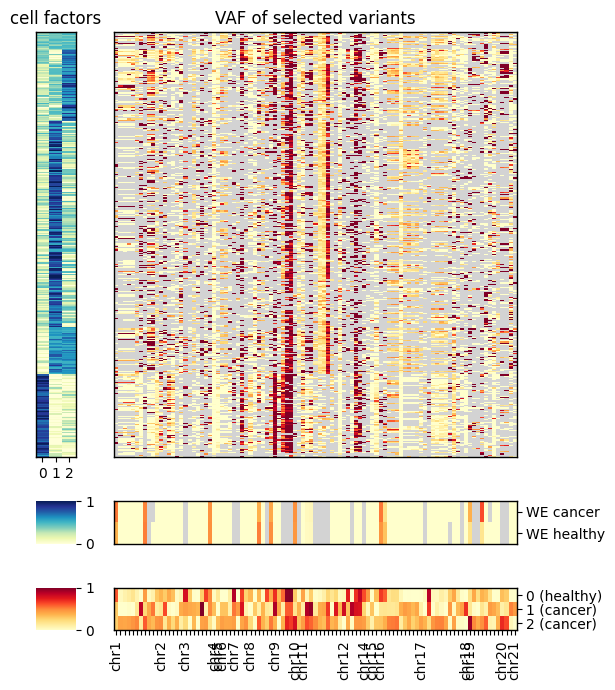

In [9]:
fig,((axs_0), (axs_1), (axs_2)) = plt.subplots(3,2,
                                               gridspec_kw={'height_ratios':[1,.1, .1],
                                                            'width_ratios':[.1,1]}, 
                                               figsize=(6,7))
args = {"vmin":0, "vmax":1, "cbar_ax":axs_2[0], "cmap":var_cmap}

#################
# plot C matrix # 
#################
g = sns.heatmap(adata.obsm["C"], 
                ax=axs_0[0], 
                cmap=cell_cmap,  xticklabels=[0,1,2], yticklabels=[], vmin=0, #vmax=1, 
                cbar_ax=axs_1[0])
axs_0[0].set_title("cell factors")
set_border(g)




###################################
# plot vars enriched in WE cancer # 
###################################
# get relevant variants
sub_vars = np.any(np.abs(np.diff(V, axis=1))>.3, axis=1)
sub_vars &= expressed
# plot VAF
g = sns.heatmap(VAF[:,sub_vars], ax=axs_0[1], yticklabels=[], xticklabels=[], **args)
axs_0[1].set_title("VAF of selected variants")
set_border(g)
# plot the variant weights
ylab = make_labels(adata[:,sub_vars])
g = sns.heatmap(V[sub_vars].T, ax=axs_2[1], xticklabels=ylab, 
                **args)
axs_2[1].yaxis.tick_right() 
axs_2[1].set_yticks([i + 0.5 for i in range(adata.varm["V"].shape[1])])
axs_2[1].set_yticklabels([str(i) + " ("+adata.uns["factor_labels"][i]+")" for i in range(adata.varm["V"].shape[1])], 
                          rotation=0)
set_border(g)
# plot the VAF in whole exome
g = sns.heatmap(WE_VAF[sub_vars].T, ax=axs_1[1], xticklabels=[], **args)
axs_1[1].yaxis.tick_right() 
axs_1[1].set_yticks([i + 0.5 for i in range(2)])
axs_1[1].set_yticklabels(["WE cancer", "WE healthy"], rotation=0)
set_border(g)
    

#################
# show and save # 
#################
plt.tight_layout()
save_path = "../figures/AML-S2_P4-WE-variants.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)
plt.show()
plt.close()

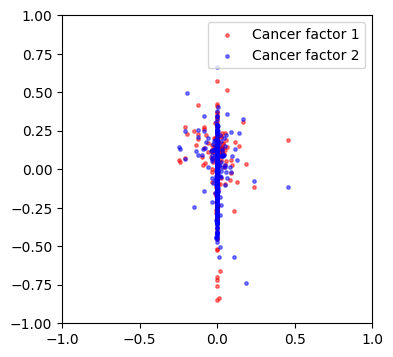

In [13]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
y = V[:,0]-V[:,1]
#plt.scatter((WE_VAF[:,0]-WE_VAF[:,1])[~expressed], y[~expressed], alpha=.5, color="grey", s=6)
plt.scatter((WE_VAF[:,0]-WE_VAF[:,1])[expressed], y[expressed], alpha=.5, color="red", s=6, label="Cancer factor 1")
y = V[:,0]-V[:,2]
plt.scatter((WE_VAF[:,0]-WE_VAF[:,1])[expressed], y[expressed], alpha=.5, color="blue", s=6, label="Cancer factor 2")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
save_path = "../figures/AML-S2_P4-weights.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)